In [1]:
#importamos librerias para la carga de los datos csv
import pandas as pd
import numpy as np

#cargamos los csv en dos dataframes diferentes, fake vs real news
dataset = pd.read_csv(r"XXX\WELFake_Dataset.csv")

#Eliminamos las columnas que no nos hacen falta en este análisis
dataset.drop("Unnamed: 0",axis=1,inplace=True)
dataset.drop("title",axis=1,inplace=True)

#Revisamos el estado de los datos
print("En dataset hay {} nulos".format(dataset.isnull().sum()))

#Eliminamos los null values, ya que contamos con registros suficientes
dataset = dataset.dropna()

#Se hace un shuffle de los registros
dataset = dataset.sample(frac=1, ignore_index=True, random_state=42)

En dataset hay text     39
label     0
dtype: int64 nulos


# Pre-preprocesado
Dado que en las noticias reales se incluye información sobre el periódico del cual se ha extraido esta información, vamos a eliminar este dato para que el modelo no pueda aprender de ello, pues hace de la tarea algo trivial. 

In [2]:
#Generamos una función para eliminar el texto que figura antes del guión, el cual da información sobre el periódico del cual se ha extraido.

def eliminar_texto_previo(text):
    # Dividir el texto en función del guión y quedarse con la segunda parte (si existe)
    partes = text.split(" — ", 1)
    if len(partes) > 1:
        return partes[1]
    else:
        return text
    
dataset["text"] = dataset.text.apply(eliminar_texto_previo)

# Preprocesado 

In [3]:
#en primer lugar, se debe separar la información en train y test
from sklearn.model_selection import train_test_split

X_data = dataset["text"] #Analizaremos el texto de la noticia
y_data = dataset["label"] #Dataframe para que mantenga el column name
X_train, X_test, y_train, y_test = train_test_split(
    X_data,y_data, test_size=0.25, random_state=42
)

# Eliminación de stopwords y tokenización


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string 

def tokenizado_stopwords (texto):
    texto = texto.lower() #lo pasamos a minúsculas
    palabras = word_tokenize(texto) #tokenizado del texto
    stop_words = set(stopwords.words('english')) #cargamos el set de stopwords en inglés

    #eliminamos las stopwords del texto tokenizado
    palabras_filtradas = []
    for i in palabras:
        if i not in stop_words and i not in [".",",",":",";"," ","(",")","’","“","”","@","?","-","—","_"] and i not in string.punctuation : #He intentado eliminar todos los caracteres que pueda haber en el texto y que no sean palabras
            palabras_filtradas.append(i)
    return ' '.join(palabras_filtradas)
      
X_train_word_tokenize = X_train.apply(tokenizado_stopwords)
X_test_word_tokenize = X_test.apply(tokenizado_stopwords)

# Entrenando modelos de vectorización

In [5]:
#MODELO 1 - COUNTVECTORIZER
from sklearn.feature_extraction.text import CountVectorizer

#iniciamos instancia y tokenizamos el texto contando con bigramas también
count_vectorizer = CountVectorizer(stop_words="english")
CVec_X_train = count_vectorizer.fit_transform(X_train_word_tokenize)

#Debemos hacer los mismo con el test
CVec_X_test =count_vectorizer.transform(X_test_word_tokenize)

#MODELO 2 - TfidfVectorizer (Countvectorizer + tfidtransformer)
from sklearn.feature_extraction.text import TfidfVectorizer

Tfid_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
Tfid_X_train = Tfid_vectorizer.fit_transform(X_train_word_tokenize)
Tfid_X_test = Tfid_vectorizer.transform(X_test_word_tokenize)

#Guardamos los modelos entrenados en pickle
import pickle

with open("CountVectorizer_model.pkl", 'wb') as file:
    pickle.dump(count_vectorizer, file)

with open("TfidVectorizer_model.pkl", 'wb') as file:
    pickle.dump(Tfid_vectorizer, file)

# Modelos de predicción

## Multinomial Naive Bayes

In [6]:
#SE PRUEBA MULTINOMIAL NB EN LOS DOS TOKENIZADOS REALIZADOS PARA COMPARAR
from sklearn.naive_bayes import MultinomialNB
import time #Esto nos permitirá calcular el tiempo de aprendizaje de nuestros modelos entrenados

#Lo entrenamos sobre los datos de train y probamos en test - COUNTVECTORIZER
start_time = time.time()
Multi_NB_CV=MultinomialNB()
Multi_NB_CV.fit(CVec_X_train,y_train)
Multi_NB_CV_score_train = Multi_NB_CV.score(CVec_X_train,y_train)
end_time = time.time()
training_time_multinb_cvec = end_time - start_time

Multi_NB_CV_predict = Multi_NB_CV.predict(CVec_X_test)
Multi_NB_CV_score_predict = Multi_NB_CV.score(CVec_X_test, y_test)

#Lo entrenamos sobre los datos de train y probamos en test - TfidfVectorizer
start_time = time.time()
Multi_NB_Tfid=MultinomialNB()
Multi_NB_Tfid.fit(Tfid_X_train,y_train)
Multi_NB_Tfid_score_train = Multi_NB_Tfid.score(Tfid_X_train,y_train)
end_time = time.time()
training_time_multinb_tfid = end_time - start_time

Multi_NB_Tfid_predict = Multi_NB_Tfid.predict(Tfid_X_test)
Multi_NB_Tfid_score_predict = Multi_NB_Tfid.score(Tfid_X_test, y_test)

#imprimimos los resultados y scores
print("Tiempo de entrenamiento CVec: {}".format(training_time_multinb_cvec))
print("Score en train con CountVectorizer:{:.2f}".format(Multi_NB_CV_score_train))
print("Score en predict con CountVectorizer:{:.2f}".format(Multi_NB_CV_score_predict))

print("Tiempo de entrenamiento Tfid: {}".format(training_time_multinb_tfid))
print("Score en train con TfidfVectorizer:{:.2f}".format(Multi_NB_Tfid_score_train))
print("Score en predict con TfidfVectorizer:{:.2f}".format(Multi_NB_Tfid_score_predict))


#Guardamos los dos modelos entrenados con pickle
with open("MultinomialNB_CountVect_model.pkl", 'wb') as file:
    pickle.dump(Multi_NB_CV, file)

with open("MultinomialNB_Tfid_model.pkl", 'wb') as file:
    pickle.dump(Multi_NB_Tfid, file)

Tiempo de entrenamiento CVec: 0.12113118171691895
Score en train con CountVectorizer:0.91
Score en predict con CountVectorizer:0.89
Tiempo de entrenamiento Tfid: 0.1003715991973877
Score en train con TfidfVectorizer:0.88
Score en predict con TfidfVectorizer:0.87


## Regresión Logística

In [7]:
from sklearn.linear_model import LogisticRegressionCV

#Regresión logística con datos tokenizados con CountVectorizer
start_time = time.time()
LogRegCV_countvect = LogisticRegressionCV(random_state=42, n_jobs=-1, max_iter=500, cv=10)
LogRegCV_countvect.fit(CVec_X_train,y_train)
end_time = time.time()
training_time_logreg_cvec = end_time - start_time
LogRegCV__countvect_prediction = LogRegCV_countvect.predict(CVec_X_test)

#Regresión logística con datos tokenizados con Tfid
start_time = time.time()
LogRegCV_Tfit = LogisticRegressionCV(random_state=42, n_jobs=-1, max_iter=500, cv=10)
LogRegCV_Tfit.fit(Tfid_X_train,y_train)
end_time = time.time()
training_time_logreg_tfid = end_time - start_time
LogRegCV_Tfit_prediction = LogRegCV_Tfit.predict(Tfid_X_test)

print("Tiempo de entrenamiento CVec: {}".format(training_time_logreg_cvec))
print("El score del modelo de Regresion Logística y CountVectorizer en train es:{:.2f}".format(LogRegCV_countvect.score(CVec_X_train,y_train)))
print("El score del modelo de Regresion Logística y CountVectorizer en test es:{:.2f}".format(LogRegCV_countvect.score(CVec_X_test,y_test)))

print("Tiempo de entrenamiento Tfid: {}".format(training_time_logreg_tfid))
print("El score del modelo de Regresion Logística y Tfid en train es:{:.2f}".format(LogRegCV_Tfit.score(Tfid_X_train,y_train)))
print("El score del modelo de Regresion Logística y Tfid en test es:{:.2f}".format(LogRegCV_Tfit.score(Tfid_X_test,y_test)))

#Guardamos en pickle
with open("LogReg_CountVect_model.pkl", 'wb') as file:
    pickle.dump(LogRegCV_countvect, file)

with open("LogReg_Tfid_model.pkl", 'wb') as file:
    pickle.dump(LogRegCV_Tfit, file)

Tiempo de entrenamiento CVec: 505.44406151771545
El score del modelo de Regresion Logística y CountVectorizer en train es:0.98
El score del modelo de Regresion Logística y CountVectorizer en test es:0.95
Tiempo de entrenamiento Tfid: 308.6148808002472
El score del modelo de Regresion Logística y Tfid en train es:1.00
El score del modelo de Regresion Logística y Tfid en test es:0.96


## Árboles de clasificación


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

start_time = time.time()
Random_forest_Cvec = RandomForestClassifier(n_estimators=100, random_state=42)
Random_forest_Cvec.fit(CVec_X_train, y_train)
end_time = time.time()
training_time_rtc_cvec = end_time - start_time
Random_forest_prediction_Cvec = Random_forest_Cvec.predict(CVec_X_test)
accuracy_Cvec = accuracy_score(y_test, Random_forest_prediction_Cvec)

print("Tiempo de entrenamiento CVec: {}".format(training_time_rtc_cvec))
print(f'Precisión con CountVectorizer en train: {Random_forest_Cvec.score(CVec_X_train, y_train):.2f}')
print(f'Precisión con CountVectorizer en test: {accuracy_Cvec:.2f}')

start_time = time.time()
Random_forest_Tfid = RandomForestClassifier(n_estimators=100, random_state=42)
Random_forest_Tfid.fit(Tfid_X_train, y_train)
end_time = time.time()
training_time_rtc_tfid = end_time - start_time
Random_forest_prediction_Tfid = Random_forest_Tfid.predict(Tfid_X_test)
accuracy_Tfid = accuracy_score(y_test, Random_forest_prediction_Tfid)

print("Tiempo de entrenamiento Tfid: {}".format(training_time_rtc_tfid))
print(f'Precisión con Tfid en train: {Random_forest_Tfid.score(Tfid_X_train, y_train):.2f}')
print(f'Precisión con Tfid en test: {accuracy_Tfid:.2f}')

# #Informe de clasificación y guardado en un txt
# print(classification_report(y_test, Random_forest_prediction_Cvec))
# with open("RandomForest_classreport_CountVect.txt", "w") as report_file:
#     report_file.write(classification_report(y_test, Random_forest_prediction_Cvec))

# print(classification_report(y_test, Random_forest_prediction_Tfid))
# with open("RandomForest_classreport_Tfid.txt", "w") as report_file:
#     report_file.write(classification_report(y_test, Random_forest_prediction_Tfid))

#Guardamos en pickle
with open("RandomForest_Tfid_model.pkl", 'wb') as file:
    pickle.dump(Random_forest_Cvec, file)

with open("RandomForest_Tfid_model.pkl", 'wb') as file:
    pickle.dump(Random_forest_Tfid, file)

Tiempo de entrenamiento CVec: 469.3776230812073
Precisión con CountVectorizer en train: 1.00
Precisión con CountVectorizer en test: 0.93
Tiempo de entrenamiento Tfid: 404.78582072257996
Precisión con Tfid en train: 1.00
Precisión con Tfid en test: 0.93


## GridSearchCV con Vector Soporte (SVC)

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Por probar el uso de GRIDSEARCH, buscaremos los mejores hiperparámetros para nuestro SVM y los datos que tenemos. 
# Utilizaremos únicamente los datos obtenidos con CountVectorizer por cuestiones de tiempo y utilizaremos los mismos hiperparámetros con Tfid 

# Crear una instancia del clasificador SVM
support_vector = SVC()

#definimos los hiperparámetros que vamos a probar para svm lineal,polinómico y gausiano
param_grid = {
    "C":[0.1,1,5,10],
    'kernel': ['linear', 'rbf', 'poly'],
}

#creamos objeto gridsearch
search = GridSearchCV(support_vector, param_grid, scoring='accuracy', verbose=1, n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
search.fit(CVec_X_train, y_train)
print("Mejores hiperparámetros: {}".format(search.best_params_))
print("Mejor estimador: {}".format(search.best_score_))
y_pred_SVC = search.predict(CVec_X_test)

#Extraemos las métricas de calidad
from sklearn.metrics import confusion_matrix
accuracy = accuracy_score(y_test, y_pred_SVC)
print("----" * 10)
print(f'Precisión en los datos de prueba: {accuracy:.2f}')
print("----" * 10)
print(classification_report(y_test, y_pred_SVC))

with open("Gridsearch_classreport.txt", "w") as report_file:
    report_file.write(classification_report(y_test, y_pred_SVC))

print("----" * 10)
print(confusion_matrix(y_test, y_pred_SVC))

#Guardamos modelo con pickle
with open("GridSearch_SVC_CrossVal_model.pkl", 'wb') as file:
    pickle.dump(search, file)

# Vector Soporte (SVC)

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

#Uso de SVC con CVec
start_time = time.time()
support_vector_CVec = SVC(C=5,kernel="rbf") #Utilizamos los mismos hiperparámetros 
support_vector_CVec.fit(CVec_X_train, y_train)
end_time = time.time()
training_time_svc_cvec = end_time - start_time
support_vector_CVec_predict = support_vector_CVec.predict(CVec_X_test)
accuracy_support_vector_CVec_train =support_vector_CVec.score(CVec_X_train,y_train) 
accuracy_support_vector_CVec_test = accuracy_score(y_test, support_vector_CVec_predict)

print("Tiempo de entrenamiento CVec: {}".format(training_time_svc_cvec))
print(f'Precisión con SVC y CVec en train: {accuracy_support_vector_CVec_train:.2f}')
print(f'Precisión con SVC y CVec en test: {accuracy_support_vector_CVec_test:.2f}')

#Guardamos modelo con pickle
with open("SVC_CVec_model.pkl", 'wb') as file:
    pickle.dump(support_vector_CVec, file)

#Uso de SVC con Tdif
start_time = time.time()
support_vector_Tfid = SVC(C=5,kernel="rbf") #Utilizamos los mismos hiperparámetros 
support_vector_Tfid.fit(Tfid_X_train, y_train)
end_time = time.time()
training_time_svc_tfid = end_time - start_time
support_vector_Tfid_predict = support_vector_Tfid.predict(Tfid_X_test)
accuracy_support_vector_Tfid_train =support_vector_Tfid.score(Tfid_X_train,y_train) 
accuracy_support_vector_Tfid_test = accuracy_score(y_test, support_vector_Tfid_predict)

print("Tiempo de entrenamiento Tfid: {}".format(training_time_svc_tfid))
print(f'Precisión con SVC y Tfid en train: {accuracy_support_vector_Tfid_train:.2f}')
print(f'Precisión con SVC y Tfid en test: {accuracy_support_vector_Tfid_test:.2f}')

#Guardamos modelo con pickle
with open("SVC_Tfid_model.pkl", 'wb') as file:
    pickle.dump(support_vector_Tfid, file)


Tiempo de entrenamiento CVec: 5449.605561971664
Precisión con SVC y CVec en train: 0.99
Precisión con SVC y CVec en test: 0.95
Tiempo de entrenamiento Tfid: 7102.917524576187
Precisión con SVC y Tfid en train: 0.51
Precisión con SVC y Tfid en test: 0.96


## XGBoost

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier  # Para clasificación

start_time = time.time()
XGBoost_model_CVec = XGBClassifier(
    objective='binary:logistic',  # Para clasificación binaria
    max_depth=3,                 # Profundidad máxima del árbol. Escojo 3 para evitar overfitting
    learning_rate=0.1,           # Tasa de aprendizaje
    n_estimators=100             # Número de árboles (estimadores)
)

XGBoost_model_CVec.fit(CVec_X_train,y_train)
end_time = time.time()
training_time_xgboost_cvec = end_time - start_time
XGBoost_prediction_CVec = XGBoost_model_CVec.predict(CVec_X_test)
XGBoost_CVec_prediction_accuracy_train = XGBoost_model_CVec.score(CVec_X_train,y_train)
XGBoost_accuracy_CVec = accuracy_score(y_test, XGBoost_prediction_CVec) 

print("Tiempo de entrenamiento cvec: {}".format(training_time_xgboost_cvec))
print("XGBoost has an accuracty in train of {:.2f}".format(XGBoost_CVec_prediction_accuracy_train))
print("XGBoost has an accuracty in test of {:.2f}".format(XGBoost_accuracy_CVec))

#Guardamos modelo con pickle
with open("XGBoost_CVec_model.pkl", 'wb') as file:
    pickle.dump(XGBoost_model_CVec, file)

start_time = time.time()
XGBoost_model_Tfid = XGBClassifier(
    objective='binary:logistic',  # Para clasificación binaria
    max_depth=3,                 # Profundidad máxima del árbol. Escojo 3 para evitar overfitting
    learning_rate=0.1,           # Tasa de aprendizaje
    n_estimators=100             # Número de árboles (estimadores)
)

XGBoost_model_Tfid.fit(Tfid_X_train,y_train)
end_time = time.time()
training_time_xgboost_tfid = end_time - start_time
XGBoost_prediction_Tfid = XGBoost_model_Tfid.predict(Tfid_X_test)
XGBoost_Tfid_prediction_accuracy_train = XGBoost_model_Tfid.score(Tfid_X_train,y_train)
XGBoost_accuracy_Tfid = accuracy_score(y_test, XGBoost_prediction_Tfid) 

print("Tiempo de entrenamiento tfid: {}".format(training_time_xgboost_tfid))
print("XGBoost has an accuracty in train of {:.2f}".format(XGBoost_Tfid_prediction_accuracy_train))
print("XGBoost has an accuracty in test of {:.2f}".format(XGBoost_accuracy_Tfid))

#Guardamos modelo con pickle
with open("XGBoost_Tfid_model.pkl", 'wb') as file:
    pickle.dump(XGBoost_model_Tfid, file)


Tiempo de entrenamiento cvec: 47.009206771850586
XGBoost has an accuracty in train of 0.92
XGBoost has an accuracty in test of 0.91
Tiempo de entrenamiento tfid: 88.05734276771545
XGBoost has an accuracty in train of 0.92
XGBoost has an accuracty in test of 0.92


# EDA MODELOS MACHINE LEARNING 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## CURVA ROC

In [12]:

#Debemos calcular la curva ROC y el área bajo la curva (Este índice se puede interpretar como la probabilidad de que un clasificador ordenará o puntuará una 
# instancia positiva elegida aleatoriamente más alta que una negativa.)

#MultinomialNB_CVec
fpr_mnb_cvec, tpr_mnb_cvec, thresholds_mnb_cvec = roc_curve(y_test, Multi_NB_CV_predict)
roc_auc_mnb_cvec = roc_auc_score(y_test, Multi_NB_CV_predict)

#MultinomialNB_Tfid
fpr_mnb_tfid, tpr_mnb_tfid, thresholds_mnb_tfid = roc_curve(y_test, Multi_NB_Tfid_predict)
roc_auc_mnb_tfid = roc_auc_score(y_test, Multi_NB_Tfid_predict)

#Logistic Regression CVec
fpr_lr_cvec, tpr_lr_cvec, thresholds_lr_cvec = roc_curve(y_test, LogRegCV__countvect_prediction)
roc_auc_lr_cvec = roc_auc_score(y_test, LogRegCV__countvect_prediction)

#Logistic Regression Tfid
fpr_lr_tfid, tpr_lr_tfid, thresholds_lr_tfid = roc_curve(y_test, LogRegCV_Tfit_prediction)
roc_auc_lr_tfid = roc_auc_score(y_test, LogRegCV_Tfit_prediction)

#RandomForestClassifier CVec
fpr_rfc_cvec, tpr_rfc_cvec, thresholds_rfc_cvec = roc_curve(y_test, Random_forest_prediction_Cvec)
roc_auc_rfc_cvec = roc_auc_score(y_test, Random_forest_prediction_Cvec)

#RandomForestClassifier Tfid
fpr_rfc_tfid, tpr_rfc_tfid, thresholds_rfc_tfid = roc_curve(y_test, Random_forest_prediction_Tfid)
roc_auc_rfc_tfid = roc_auc_score(y_test, Random_forest_prediction_Tfid)

#SVC CVec
fpr_svc_cvec, tpr_svc_cvec, thresholds_svc_cvec = roc_curve(y_test, support_vector_CVec_predict)
roc_auc_svc_cvec = roc_auc_score(y_test, support_vector_CVec_predict)

#SVC Tfid
fpr_svc_tfid, tpr_svc_tfid, thresholds_svc_tfid = roc_curve(y_test, support_vector_Tfid_predict)
roc_auc_svc_tfid = roc_auc_score(y_test, support_vector_Tfid_predict)

#XGBoost CVec
fpr_xgboost_cvec, tpr_xgboost_cvec, thresholds_xgboost_cvec = roc_curve(y_test, XGBoost_prediction_CVec)
roc_auc_xgboost_cvec = roc_auc_score(y_test, XGBoost_prediction_CVec)

#XGBoost Tfid
fpr_xgboost_tfid, tpr_xgboost_tfid, thresholds_xgboost_tfid = roc_curve(y_test, XGBoost_prediction_Tfid)
roc_auc_xgboost_tfid = roc_auc_score(y_test, XGBoost_prediction_Tfid)


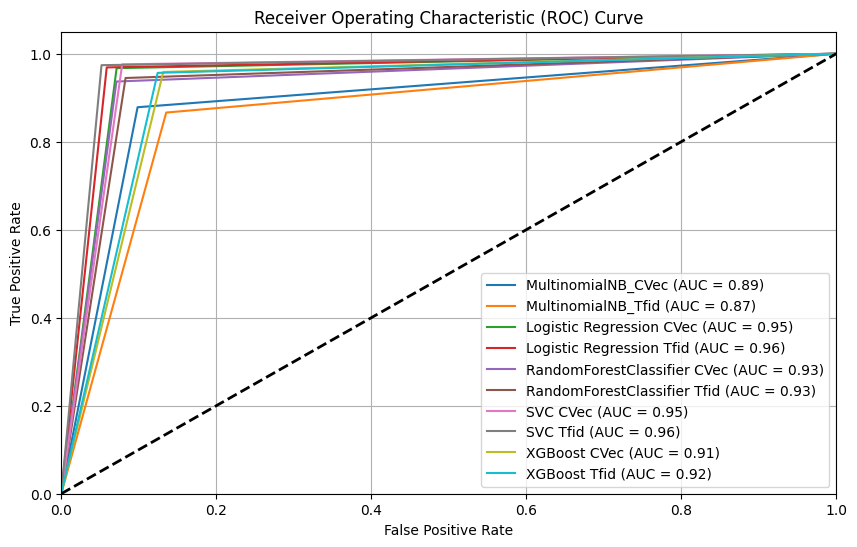

In [13]:


# Create a dictionary to hold the model names, ROC curves, and ROC AUC scores
models = {
    'MultinomialNB_CVec': (fpr_mnb_cvec, tpr_mnb_cvec, roc_auc_mnb_cvec),
    'MultinomialNB_Tfid': (fpr_mnb_tfid, tpr_mnb_tfid, roc_auc_mnb_tfid),
    'Logistic Regression CVec': (fpr_lr_cvec, tpr_lr_cvec, roc_auc_lr_cvec),
    'Logistic Regression Tfid': (fpr_lr_tfid, tpr_lr_tfid, roc_auc_lr_tfid),
    'RandomForestClassifier CVec': (fpr_rfc_cvec, tpr_rfc_cvec, roc_auc_rfc_cvec),
    'RandomForestClassifier Tfid': (fpr_rfc_tfid, tpr_rfc_tfid, roc_auc_rfc_tfid),
    'SVC CVec': (fpr_svc_cvec, tpr_svc_cvec, roc_auc_svc_cvec),
    'SVC Tfid': (fpr_svc_tfid, tpr_svc_tfid, roc_auc_svc_tfid),
    'XGBoost CVec': (fpr_xgboost_cvec, tpr_xgboost_cvec, roc_auc_xgboost_cvec),
    'XGBoost Tfid': (fpr_xgboost_tfid, tpr_xgboost_tfid, roc_auc_xgboost_tfid),
}

# Plot ROC curves
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr, roc_auc) in models.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


## Area bajo la curva (AUC)

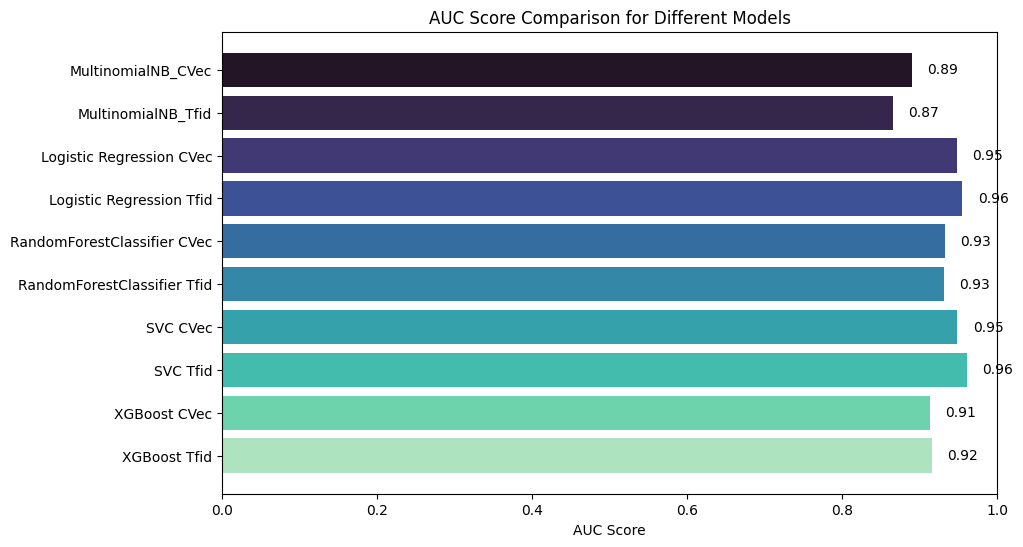

In [49]:
#Area bajo la curva
# Definir los nombres de los modelos y sus AUC correspondientes
model_names = [
    'MultinomialNB_CVec', 'MultinomialNB_Tfid',
    'Logistic Regression CVec', 'Logistic Regression Tfid',
    'RandomForestClassifier CVec', 'RandomForestClassifier Tfid',
    'SVC CVec', 'SVC Tfid',
    'XGBoost CVec', 'XGBoost Tfid'
]

auc_scores = [
    roc_auc_mnb_cvec, roc_auc_mnb_tfid,
    roc_auc_lr_cvec, roc_auc_lr_tfid,
    roc_auc_rfc_cvec, roc_auc_rfc_tfid,
    roc_auc_svc_cvec, roc_auc_svc_tfid,
    roc_auc_xgboost_cvec, roc_auc_xgboost_tfid
]

#Colors
colors = sns.color_palette("mako", len(model_names))

# Crear un gráfico de barras para comparar los AUC de los modelos
plt.figure(figsize=(10, 6))
plt.barh(model_names, auc_scores, color=colors)
plt.xlabel('AUC Score')
plt.title('AUC Score Comparison for Different Models')
plt.xlim(0.0, 1.0)  # Establecer límites del eje x
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el mejor modelo en la parte superior

# Mostrar el valor del AUC en cada barra
for i, auc_score in enumerate(auc_scores):
    plt.text(auc_score + 0.02, i, f'{auc_score:.2f}', va='center')

# Mostrar el gráfico
plt.show()

## Matriz de confusión

Verdadero Positivo (TP): Predicho Verdadero y Verdadero en realidad.
Verdadero Negativo (TN): Predicho Falso y Falso en realidad.
Falso Positivo (FP): Predicción de verdadero y falso en la realidad.
Falso Negativo (FN): Predicción de falso y verdadero en la realidad.

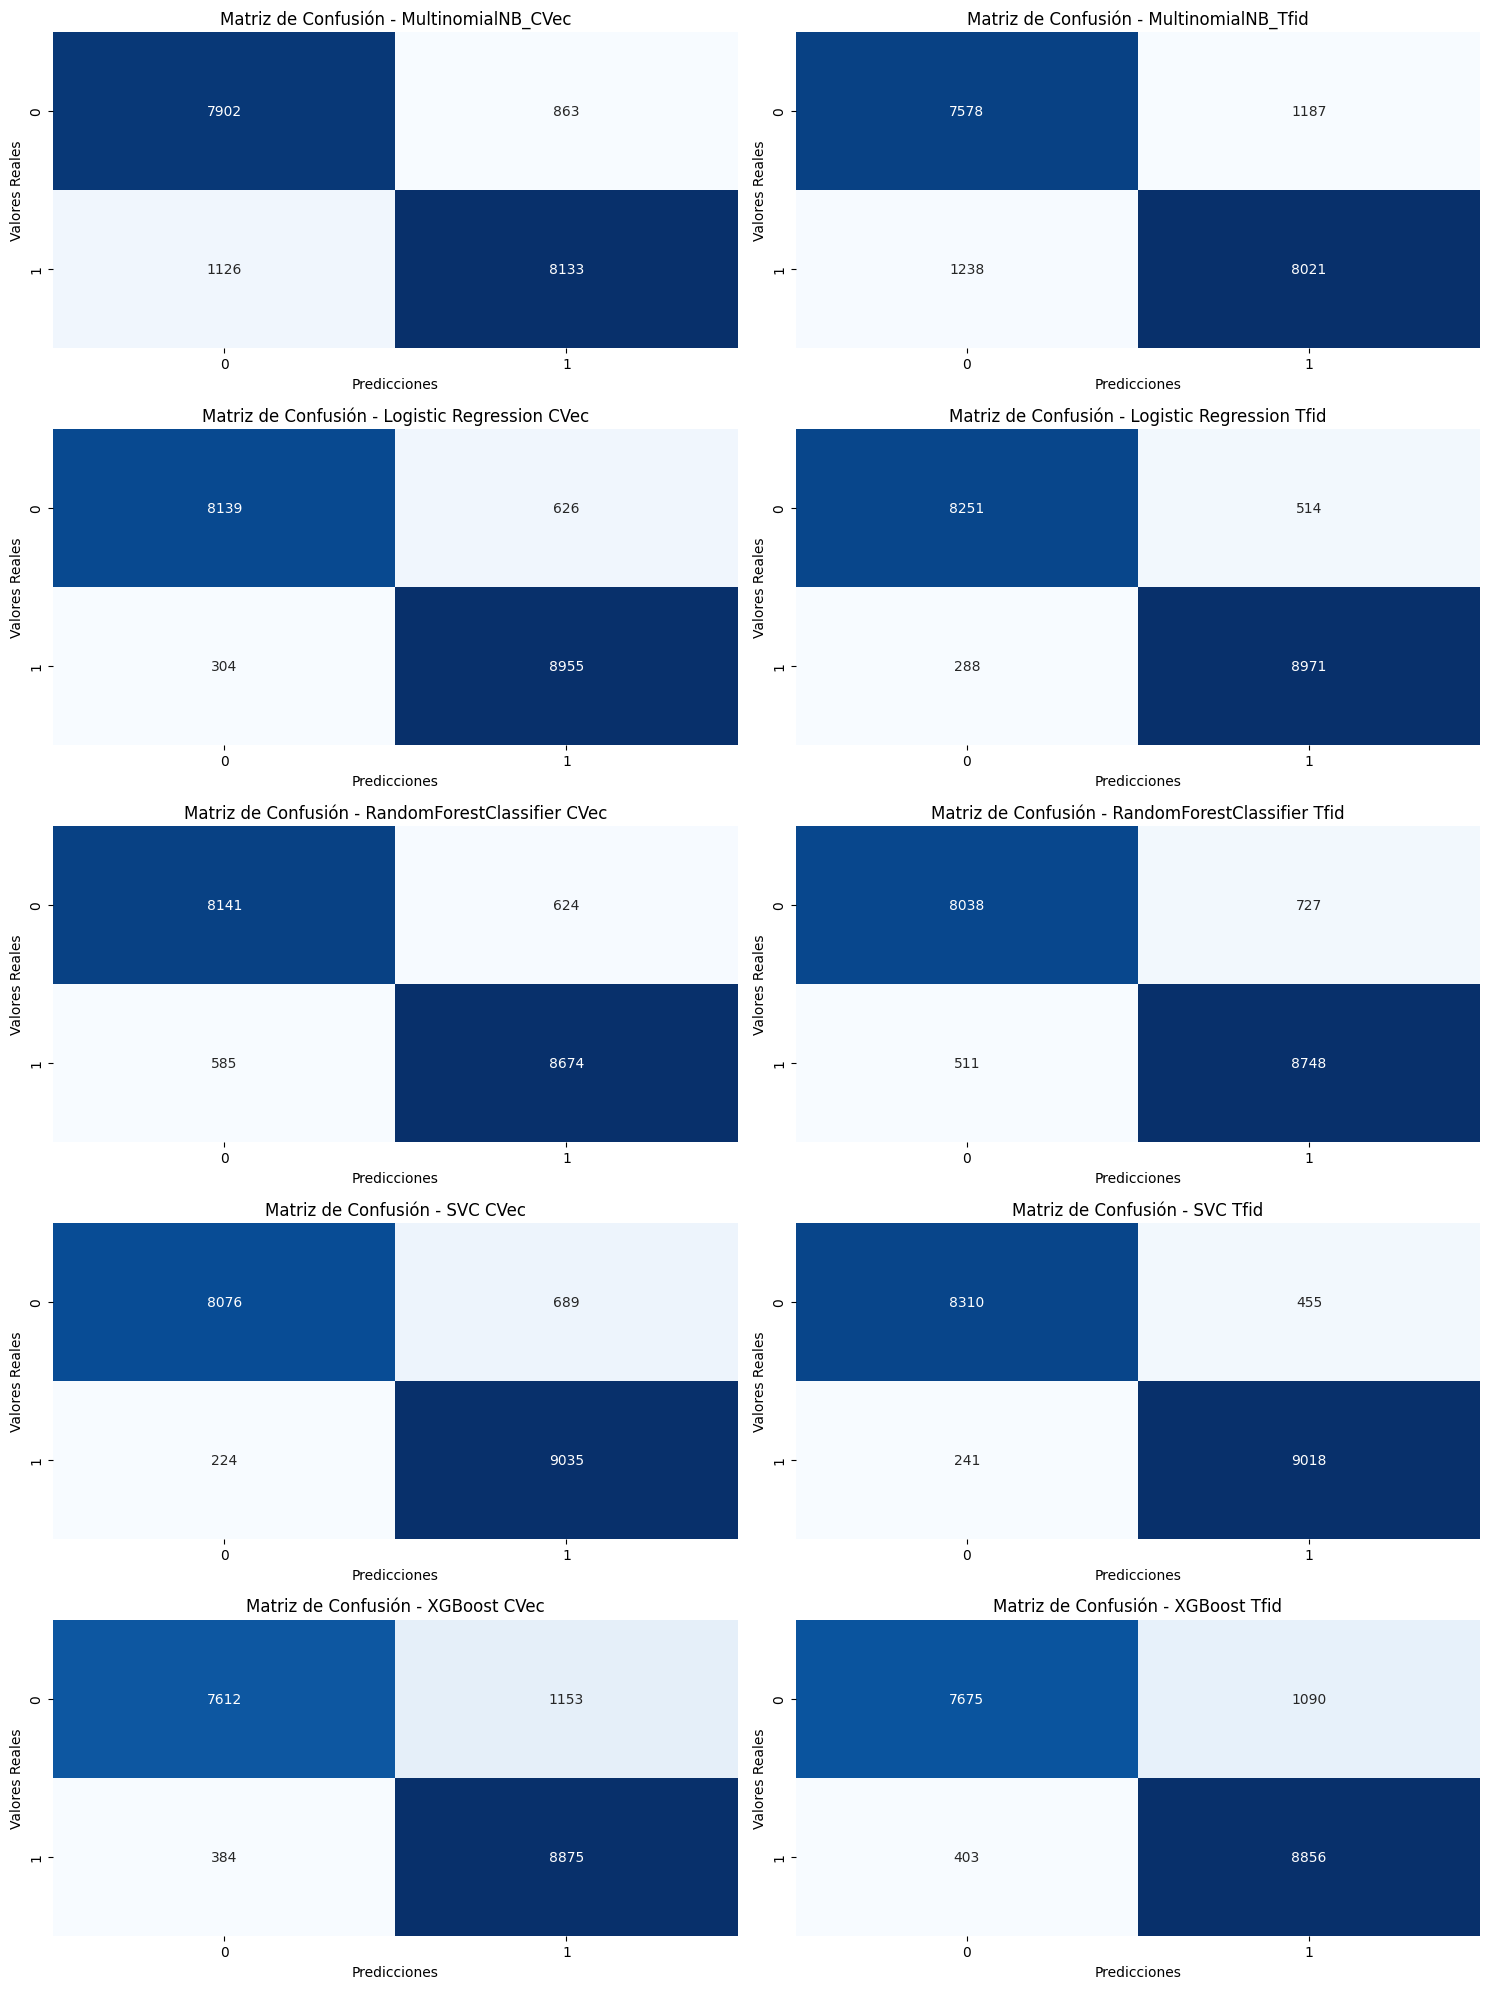

In [51]:
# Lista de modelos y sus predicciones

models = [
    ('MultinomialNB_CVec', Multi_NB_CV_predict),
    ('MultinomialNB_Tfid', Multi_NB_Tfid_predict),
    ('Logistic Regression CVec', LogRegCV__countvect_prediction),
    ('Logistic Regression Tfid', LogRegCV_Tfit_prediction),
    ('RandomForestClassifier CVec', Random_forest_prediction_Cvec),
    ('RandomForestClassifier Tfid', Random_forest_prediction_Tfid),
    ('SVC CVec', support_vector_CVec_predict),
    ('SVC Tfid', support_vector_Tfid_predict),
    ('XGBoost CVec', XGBoost_prediction_CVec),
    ('XGBoost Tfid', XGBoost_prediction_Tfid)
]

# Definir etiquetas verdaderas (reemplaza con tus etiquetas reales)
y_true = y_test

# Crear subplots para mostrar las matrices de confusión
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, (model_name, model_predictions) in enumerate(models):
    row = i // 2
    col = i % 2
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, model_predictions)
    
    # Crear un mapa de calor de la matriz de confusión
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[row, col])
    axes[row, col].set_title(f'Matriz de Confusión - {model_name}')
    axes[row, col].set_xlabel("Predicciones")
    axes[row, col].set_ylabel("Valores Reales")

plt.tight_layout()
plt.show()

## Tiempo de entrenamiento vs accuracy 

In [21]:
Multi_NB_CV_score_predict
Multi_NB_Tfid_score_predict
LogReg_coutvect_score_predict = LogRegCV_countvect.score(CVec_X_test,y_test)
LogReg_tfid_score_predict = LogRegCV_Tfit.score(Tfid_X_test,y_test)
RandomForest_coutvect_score_predict = accuracy_Cvec
RandomForest_tfid_score_predict = accuracy_Tfid
accuracy_support_vector_CVec_test
accuracy_support_vector_Tfid_test
XGBoost_accuracy_CVec
XGBoost_accuracy_Tfid

0.9171660008877053

In [ ]:
# Colores
colores = sns.color_palette("hsv", len(nombres_modelos))

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter_objs = []  # List to store scatterplot objects

for i in range(len(nombres_modelos)):
    scatter = plt.scatter(tiempos_entrenamiento[i], accuracies_modelos[i], marker='o', c=colores[i],
                          edgecolors='black', s=100, label=nombres_modelos[i])
    scatter_objs.append(scatter)  # Store the scatterplot objects

# # Etiquetar los puntos con los nombres de los modelos
# for i, name in enumerate(nombres_modelos):
#     plt.annotate(name, (tiempos_entrenamiento[i] + 0.5, accuracies_modelos[i]), fontsize=12)

plt.xscale('log')
plt.xlabel('Tiempo de Entrenamiento (segundos)')
plt.ylabel('Precisión (Accuracy)')
plt.title('Rendimiento de Modelos vs. Tiempo de Entrenamiento')
plt.grid(True)

# Create the legend from the scatterplot objects
plt.legend(handles=scatter_objs, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Guardar Variables en pickle

In [50]:
variables_proyecto = {
"Variables_accuracy":{"Multi_NB_CV_score_predict" : Multi_NB_CV_score_predict,
"Multi_NB_Tfid_score_predict" : Multi_NB_Tfid_score_predict,
"LogReg_coutvect_score_predict" : LogReg_coutvect_score_predict,
"LogReg_tfid_score_predict" :LogReg_tfid_score_predict,
"RandomForest_coutvect_score_predict" :RandomForest_coutvect_score_predict,
"RandomForest_tfid_score_predict" : RandomForest_tfid_score_predict,
"accuracy_support_vector_CVec_test" : accuracy_support_vector_CVec_test,
"accuracy_support_vector_Tfid_test" : accuracy_support_vector_Tfid_test,
"XGBoost_accuracy_CVec" : XGBoost_accuracy_CVec,
"XGBoost_accuracy_Tfid" : XGBoost_accuracy_Tfid},

"Variables_predicciones" : [
    ('MultinomialNB_CVec', Multi_NB_CV_predict),
    ('MultinomialNB_Tfid', Multi_NB_Tfid_predict),
    ('Logistic Regression CVec', LogRegCV__countvect_prediction),
    ('Logistic Regression Tfid', LogRegCV_Tfit_prediction),
    ('RandomForestClassifier CVec', Random_forest_prediction_Cvec),
    ('RandomForestClassifier Tfid', Random_forest_prediction_Tfid),
    ('SVC CVec', support_vector_CVec_predict),
    ('SVC Tfid', support_vector_Tfid_predict),
    ('XGBoost CVec', XGBoost_prediction_CVec),
    ('XGBoost Tfid', XGBoost_prediction_Tfid)],

"Roc_curve_variables" : {
    'MultinomialNB_CVec': (fpr_mnb_cvec, tpr_mnb_cvec, roc_auc_mnb_cvec),
    'MultinomialNB_Tfid': (fpr_mnb_tfid, tpr_mnb_tfid, roc_auc_mnb_tfid),
    'Logistic Regression CVec': (fpr_lr_cvec, tpr_lr_cvec, roc_auc_lr_cvec),
    'Logistic Regression Tfid': (fpr_lr_tfid, tpr_lr_tfid, roc_auc_lr_tfid),
    'RandomForestClassifier CVec': (fpr_rfc_cvec, tpr_rfc_cvec, roc_auc_rfc_cvec),
    'RandomForestClassifier Tfid': (fpr_rfc_tfid, tpr_rfc_tfid, roc_auc_rfc_tfid),
    'SVC CVec': (fpr_svc_cvec, tpr_svc_cvec, roc_auc_svc_cvec),
    'SVC Tfid': (fpr_svc_tfid, tpr_svc_tfid, roc_auc_svc_tfid),
    'XGBoost CVec': (fpr_xgboost_cvec, tpr_xgboost_cvec, roc_auc_xgboost_cvec),
    'XGBoost Tfid': (fpr_xgboost_tfid, tpr_xgboost_tfid, roc_auc_xgboost_tfid),
},

"tiempos_entrenamiento" : [training_time_multinb_cvec,training_time_multinb_tfid,training_time_logreg_cvec,training_time_logreg_tfid,
                         training_time_rtc_cvec,training_time_rtc_tfid,training_time_svc_cvec,training_time_svc_tfid,
                         training_time_xgboost_cvec,training_time_xgboost_tfid]

}

with open('variables_proyecto.pkl', 'wb') as archivo:
    pickle.dump(variables_proyecto, archivo)